In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import mediapy as media
import numpy as np
from diffusers import DDIMScheduler

try:
    from local_sd_pipeline import LocalStableDiffusionPipeline
    from optim_utils import *
except ModuleNotFoundError:
    import os; os.chdir("..")
    from local_sd_pipeline import LocalStableDiffusionPipeline
    from optim_utils import *

%load_ext autoreload
%autoreload 2

In [ ]:
# load model
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model_id = "CompVis/stable-diffusion-v1-4"

pipe = LocalStableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    safety_checker=None,
    requires_safety_checker=False,
)
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to(device)

In [3]:
num_inference_steps = 50
guidance_scale = 7.5
num_images_per_prompt = 4
image_size = 512

In [4]:
# prompt = "The No Limits Business Woman Podcast"
# prompt = "A painting of the Great Wave off Kanagawa by Katsushika Hokusai"
prompt = "Living in the Light with Ann Graham Lotz"
print(prompt)
seed = 0

Living in the Light with Ann Graham Lotz


## Before Mitigation

100%|██████████| 50/50 [00:04<00:00, 11.97it/s]


prompt: Living in the Light with Ann Graham Lotz


,,,

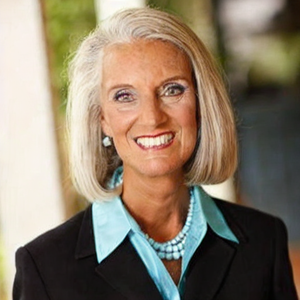
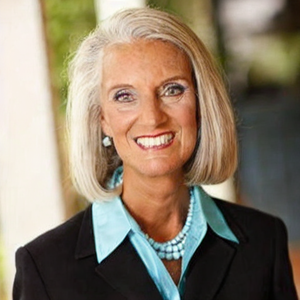
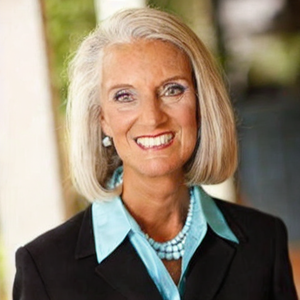
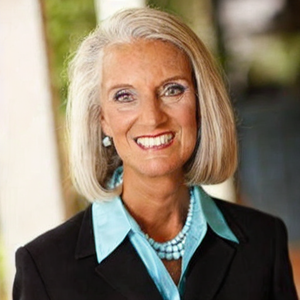

In [5]:
set_random_seed(seed)

outputs, track_stats = pipe(
    prompt,
    num_inference_steps=num_inference_steps,
    guidance_scale=guidance_scale,
    num_images_per_prompt=num_images_per_prompt,
    track_noise_norm=True,
)
outputs = outputs.images

print(f"prompt: {prompt}")
media.show_images(outputs, width=300)

## After Mitigation

In [8]:
method = "flipd"
auged_prompt_embeds = pipe.aug_prompt(
    prompt,
    num_inference_steps=num_inference_steps,
    guidance_scale=guidance_scale,
    num_images_per_prompt=1 if method == "flipd" else num_images_per_prompt,
    target_steps=[40],
    lr=0.05,
    optim_iters=30,
    # target_loss=,
    print_optim=True,
    method=method,
)

  0%|          | 0/50 [00:00<?, ?it/s]

 80%|████████  | 40/50 [00:01<00:00, 31.03it/s]

step: 0, curr loss: 10583.611328125
step: 1, curr loss: 10244.5595703125
step: 2, curr loss: 9768.017578125
step: 3, curr loss: 9102.400390625
step: 4, curr loss: 8122.8115234375
step: 5, curr loss: 6538.23876953125
step: 6, curr loss: 425.29443359375
step: 7, curr loss: -24144.50390625
step: 8, curr loss: -25680.8515625
step: 9, curr loss: -25911.068359375
step: 10, curr loss: -26083.140625
step: 11, curr loss: -26215.986328125


 80%|████████  | 40/50 [00:14<00:00, 31.03it/s]

step: 12, curr loss: -26322.134765625
step: 13, curr loss: -26404.78125
step: 14, curr loss: -26486.53125
step: 15, curr loss: -26566.158203125
step: 16, curr loss: -26664.39453125
step: 17, curr loss: -26776.28515625
step: 18, curr loss: -26914.435546875
step: 19, curr loss: -27079.951171875
step: 20, curr loss: -27268.236328125
step: 21, curr loss: -27484.970703125
step: 22, curr loss: -27722.45703125
step: 23, curr loss: -27981.63671875
step: 24, curr loss: -28279.990234375
step: 25, curr loss: -28641.75
step: 26, curr loss: -29068.654296875
step: 27, curr loss: -29553.00390625
step: 28, curr loss: -30092.880859375
step: 29, curr loss: -30680.5859375


 80%|████████  | 40/50 [00:30<00:07,  1.32it/s]


100%|██████████| 50/50 [00:04<00:00, 12.38it/s]


<class 'PIL.Image.Image'>
prompt: Living in the Light with Ann Graham Lotz


,,,

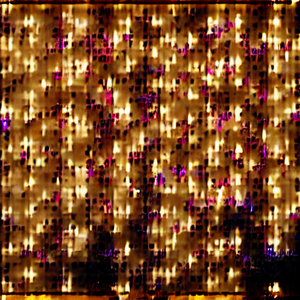
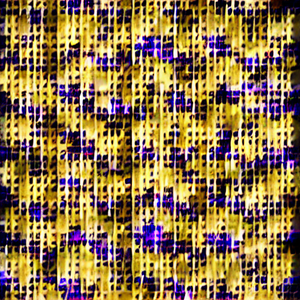
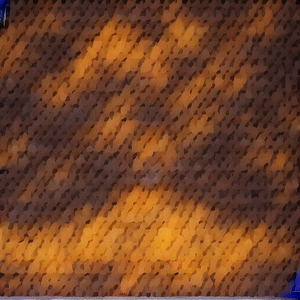
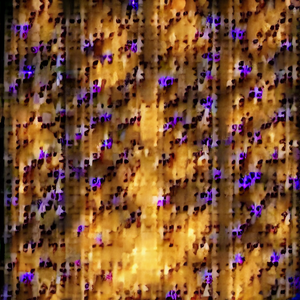

: 

In [9]:
set_random_seed(seed)

outputs, track_stats = pipe(
    prompt_embeds=auged_prompt_embeds,
    num_inference_steps=num_inference_steps,
    guidance_scale=guidance_scale,
    num_images_per_prompt=num_images_per_prompt,
    track_noise_norm=True,
    height=image_size,
    width=image_size,
)
outputs = outputs.images
print(type(outputs[0]))
print(f"prompt: {prompt}")
media.show_images(outputs, width=300)